# 1. Когортный анализ помесячного retention rate
Необходимо при помощи когортного анализа рассчитать retention rate от месяца к месяцу на промежутке в один год, начиная с начала года.

Инструменты: SQL, Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from pathlib import Path

В качестве исходных данных были выбраны данные продаж веломагазина за 2017, взятые с Kaggle. 

In [2]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',
                   sheet_name='Transactions',
                   skiprows=1,
                   parse_dates=['transaction_date']
                  )

In [3]:
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


Загрузка данных в БД

In [5]:
with open(Path.home().joinpath('.pgpass')) as auth:
    host, port, table, user, _ = auth.read().rstrip().split(':')
    
engine = create_engine(f'postgresql+psycopg2://{user}:@{host}:{port}/{table}')

In [6]:
df.to_sql('transactions', engine, index=False, if_exists='replace')

Строим CTE, в котором:
- выбираем только подтвержденные транзакции;
- выделяем месяц транзакции с помощью функции `DATE_TRUNC`;
- определяем минимальную дату активности пользователя с помощью оконной функции;
- считаем продолжительность периода активности пользователя в месяцах — для этого используем функцию `AGE`;
- считаем количество уникальных пользователей в каждой когорте для каждого месяца.

Сводим эти данные в таблицу, где строками являются месяца, столбцами — индексы когорт, начиная с 0, значениями — количество уникальных пользователей.

In [7]:
query = '''
WITH approved_orders AS (
  SELECT
    customer_id
    , transaction_date
    , DATE_TRUNC('month', transaction_date) AS transaction_month
    , MIN(DATE_TRUNC('month', transaction_date)) OVER (PARTITION BY customer_id) AS cohort_month
  FROM transactions
  WHERE order_status = 'Approved'
),
cohorts AS (
  SELECT
    COUNT(DISTINCT customer_id) AS id_counts
    , cohort_month
    , DATE_PART('month', AGE(transaction_month, cohort_month))::INT AS cohort_index
  FROM approved_orders
  GROUP BY cohort_index, cohort_month
)

SELECT
  cohort_month
  , SUM(CASE WHEN cohort_index = 0 THEN id_counts END) AS "0"
  , SUM(CASE WHEN cohort_index = 1 THEN id_counts END) AS "1"
  , SUM(CASE WHEN cohort_index = 2 THEN id_counts END) AS "2"
  , SUM(CASE WHEN cohort_index = 3 THEN id_counts END) AS "3"
  , SUM(CASE WHEN cohort_index = 4 THEN id_counts END) AS "4"
  , SUM(CASE WHEN cohort_index = 5 THEN id_counts END) AS "5"
  , SUM(CASE WHEN cohort_index = 6 THEN id_counts END) AS "6"
  , SUM(CASE WHEN cohort_index = 7 THEN id_counts END) AS "7"
  , SUM(CASE WHEN cohort_index = 8 THEN id_counts END) AS "8"
  , SUM(CASE WHEN cohort_index = 9 THEN id_counts END) AS "9"
  , SUM(CASE WHEN cohort_index = 10 THEN id_counts END) AS "10"
  , SUM(CASE WHEN cohort_index = 11 THEN id_counts END) AS "11"
FROM cohorts
GROUP BY 1
ORDER BY 1;
'''
cohort_counts = pd.read_sql(query, engine)
cohort_counts

,cohort_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-01-01,1347.0,483.0,505.0,499.0,492.0,475.0,513.0,524.0,489.0,524.0,492.0,510.0
1,2017-02-01,800.0,322.0,297.0,311.0,283.0,297.0,306.0,281.0,325.0,306.0,292.0,NaN
2,2017-03-01,484.0,167.0,172.0,164.0,180.0,184.0,173.0,209.0,186.0,180.0,NaN,NaN
3,2017-04-01,337.0,110.0,121.0,152.0,142.0,118.0,144.0,125.0,129.0,NaN,NaN,NaN
4,2017-05-01,213.0,86.0,83.0,88.0,73.0,73.0,74.0,83.0,NaN,NaN,NaN,NaN
5,2017-06-01,123.0,45.0,44.0,47.0,45.0,45.0,54.0,NaN,NaN,NaN,NaN,NaN
6,2017-07-01,77.0,26.0,26.0,32.0,37.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2017-08-01,51.0,18.0,22.0,18.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017-09-01,24.0,8.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2017-10-01,20.0,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cohort_counts.set_index('cohort_month', inplace=True)

Для выявления динамики изменений показателя удержания пользователя (retention), делим значения каждой когорты на содержание первого столбца (нулевой когорты).
Далее средствами библиотек matplotlib и seaborn визаулизируем таблицу в виде тепловой карты.

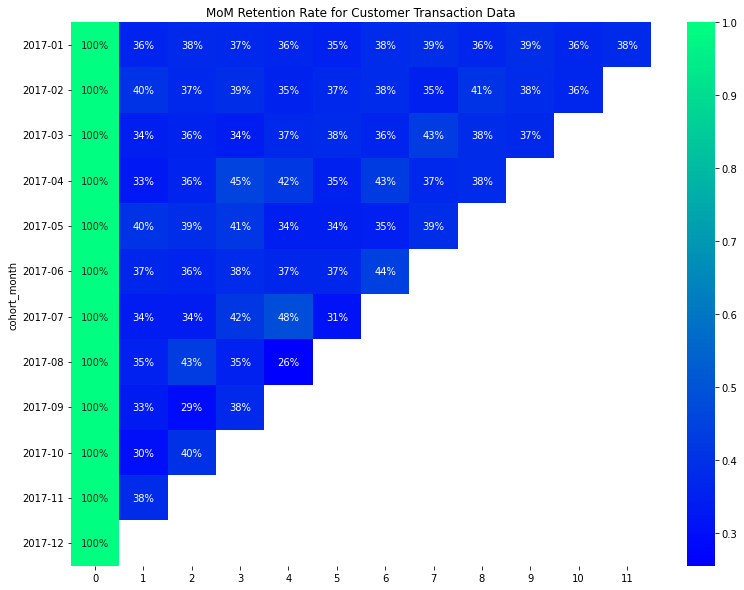

In [9]:
retention = cohort_counts.divide(cohort_counts['0'], axis=0).round(3)
retention.index = retention.index.strftime('%Y-%m')

fig, ax = plt.subplots(figsize=(13,10))
ax.set(xlabel="Cohort Index",
       ylabel="Cohort Month",
       title="MoM Retention Rate for Customer Transaction Data")
sns.heatmap(retention, annot=True, cmap='winter', fmt='.0%')
ax.tick_params(axis='y', labelrotation=360);

Проверяем результат расчетами в Python

In [11]:
df = df[['customer_id','transaction_date','online_order','order_status']]
df.head()

,customer_id,transaction_date,online_order,order_status
0,2950,2017-02-25,0.0,Approved
1,3120,2017-05-21,1.0,Approved
2,402,2017-10-16,0.0,Approved
3,3135,2017-08-31,0.0,Approved
4,787,2017-10-01,1.0,Approved


In [12]:
df = df.drop_duplicates().query('order_status == "Approved"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19761 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       19761 non-null  int64         
 1   transaction_date  19761 non-null  datetime64[ns]
 2   online_order      19407 non-null  float64       
 3   order_status      19761 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 771.9+ KB


In [13]:
from pandas.tseries.offsets import Day, MonthBegin

Выделяем `transaction_month` путем смещения даты транзакции на начало месяца.

In [14]:
df['transaction_month'] = df['transaction_date'] + Day() - MonthBegin()

Месяц когорты определяем как первую дату появления пользователя

In [15]:
df['cohort_month'] = df.groupby('customer_id')['transaction_month'].transform('min')

Индекс когорты — разница между датой транзакции и месяцем когорты.

In [17]:
df['cohort_index'] = ((df['transaction_month'] - df['cohort_month'])
                                               / np.timedelta64(1, 'M')).round().astype(int)

Считаем уникальных пользователей по группам `cohort_month,cohort_index`. Строим сводную таблицу.

In [18]:
cohort_data = df.groupby(['cohort_month','cohort_index'])['customer_id'].nunique().reset_index()
cohort_counts = cohort_data.pivot_table(
    index = 'cohort_month',
    columns = 'cohort_index',
    values = 'customer_id'   
)
cohort_data.head()

,cohort_month,cohort_index,customer_id
0,2017-01-01,0,1347
1,2017-01-01,1,483
2,2017-01-01,2,505
3,2017-01-01,3,499
4,2017-01-01,4,492


Рассчитываем retention rate по каждой когорте. Строим тепловую карту.

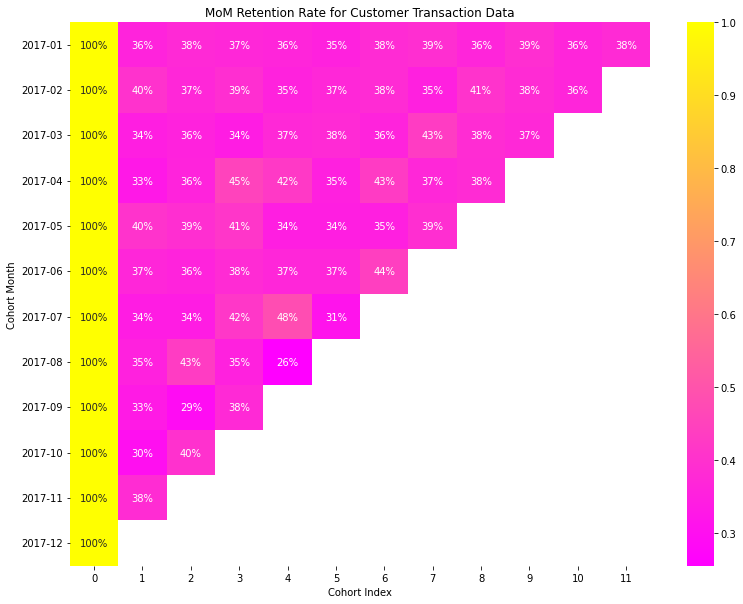

In [20]:
retention = cohort_counts.divide(cohort_counts[0], axis=0).round(3)
retention.index = retention.index.strftime('%Y-%m')

fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(retention, annot=True, cmap='spring', fmt='.0%')
ax.tick_params(axis='y', labelrotation=360)
ax.set(xlabel="Cohort Index",
       ylabel="Cohort Month",
       title="MoM Retention Rate for Customer Transaction Data");

# 2. Генерация бинарных строк

Нужно составить программу на Python для герерации бинарных строк длины N, к которых бы не было рядом стоящих единиц.

```python
generate_binary_strings(2) -> ['00', '01', '10']
generate_binary_strings(3) -> ['000', '001', '010', '100', '101']
```

In [30]:
from itertools import product
from typing import List

def generate_binary_strings(n: int) -> List[str]:
    """Output all binary strings of length N
    such that there are no repeating "1"s
    e.g. `generate_binary_strings(2) -> [00, 01, 10]`
    and `generate_binary_strings(3) -> [000, 001, 010, 100, 101]`
    """
    return list(filter(lambda x: '11' not in x, map(''.join, product('01', repeat=n))))

In [31]:
assert generate_binary_strings(2) == ['00', '01', '10']; print('ok')

ok


In [32]:
assert generate_binary_strings(3) == ['000', '001', '010', '100', '101']; print('ok')

ok
